In [ ]:
# default_exp plotting

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# plotting
> All the plotting

In [ ]:
#export
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.ndimage as ndimage
from cmath import *

from theonerig.core import *
from theonerig.processing import *
from theonerig.utils import *
from theonerig.modelling import *
from theonerig.leddome import *

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
#export
def plot_2d_fit(sta, param_d, QI=None, fit_f=sum_of_2D_gaussian, imshow_args={"vmin":-1,"vmax":1, "cmap":"gray"}):
    """
    2D STA plotting helper function to quickly check results.
    
    params:
        - sta: Frame fitted containing the 2D STA
        - param_d: Parameter dictionary of the fit for fit_f
        - fit_f: Function used for the fit
        - imshow_args: Parameters for imshow
    return:
        - the two axes list
    """
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(sta, **imshow_args)
    axes[1].imshow(img_2d_fit(sta.shape, param_d, f=fit_f), **imshow_args)
    if param_d is not None:
        param_d = {k: round(v,2) for k, v in param_d.items()}
    if QI is not None:
        QI = round(QI,2)
    axes[1].set_title("QI:"+str(QI))

    return axes

def plot_tSTA_fit(sta, param_d, QI=None, fit_f=sum_of_gaussian, frame_rate=60, ax=None):
    """
    Helper function to visualize the temporal STA fit.
    
    params:
        - sta: STA of the cell`
        - param_d: Parameter dictionary of the fit for fit_f
        - QI: Quality index of the fit
        - fit_f: Function used for the fit to plot
        - ax: Axis where to plot the figure. If None, a new figure is created
        
    return:
        - The axis of the figure
    """
    if ax is None:  
        fig, ax = plt.subplots(1,1)
        
    t = np.linspace((1-len(sta))/frame_rate, 0, len(sta))
    ax.plot(t, sta)
    ax.plot(t, fit_f(t, **param_d))
    ax.set_ylim(-1, 1)
    if QI is not None:
        QI = round(QI,2)
    if param_d is not None:
        param_d = {k: round(v,2) for k, v in param_d.items()}
    ax.set_title(str(param_d)+" QI:"+str(QI))
    
    return ax
    
def plot_chirpam_fit(cell_mean, param_d, QI=None, fit_f=sinexp_sigm, 
                     start=420, stop=960, ax=None):
    """
    Helper function to visualize the fit of a cell response to a chirp_am stimulus.
    
    params:
        - cell_mean: Cell's mean response to the stimulus
        - param_d: Parameter dictionary of the fit for fit_f
        - QI: Quality index of the fit
        - fit_f: Function used for the fit
        - start: Where the fit started in index of cell_mean
        - stop: Where the fit stopped in index of cell_mean
        - ax: Axis where to plot the figure. If None, a new figure of size (50,2) is created
        
    return:
        - The axis of the figure
    """
    if ax is None:  
        fig, ax = plt.subplots(figsize=(50,2))
    ax.plot(np.linspace(0, len(cell_mean)/60, len(cell_mean), endpoint=False), cell_mean)
    if param_d is not None:
        ax.plot(np.linspace(start/60, stop/60, stop-start, endpoint=False), 
                 fit_f(np.linspace(0, (stop-start)/60, stop-start, endpoint=False), **param_d))
        if QI is not None:
            ax.text((start/60), max(cell_mean)*80/100, str(round(QI,3)), fontdict={'size':22})
    ax.set_xlim(0, len(cell_mean)/60)
    if param_d is not None:
        param_d = {k: round(v,2) for k, v in param_d.items()}
    ax.set_title(str(param_d))
    
    return ax

def plot_chirp_freq_epoch_fit(cell_mean, param_d_l, fit_f=sin_exponent, QI_l=[None]*5, 
                              freqs=[1.875,3.75,7.5,15,30], durations=[2,2,2,1,1], start=360,
                              sampling_rate=60, ax=None):
    """
    Helper function to visualize the fit of a cell response to a chirp_freq_epoch stimulus.
    
    params:
        - cell_mean: Cell's mean response to the stimulus
        - param_d_l: Parameters dictionary list of the fits for fit_f
        - QI_l: Quality index list of the fits
        - fit_f: Function used for the fit
        - freqs: Frequency list of the epochs in Hz
        - durations: Duration list of the epochs
        - start: Where the fit started in index of cell_mean
        - sampling_rate: Sampling rate of the response in Hz
        - ax: Axis where to plot the figure. If None, a new figure of size (50,2) is created
        
    return:
        - The axis of the figure
    """
    if ax is None:  
        fig, ax = plt.subplots(figsize=(50,2))
        
    ax.plot(np.linspace(0, len(cell_mean)/sampling_rate, len(cell_mean), endpoint=False), cell_mean)
    len_fits = [int(dur*freq)*int(sampling_rate/freq) for dur,freq in zip(durations, freqs)] 
    cursor = start
    edgecut = 10
    bestfit = param_d_l[0], 0
    for len_fit, dur, params_d, QI in zip(len_fits, durations, param_d_l, QI_l):
        cursor  += edgecut
        len_fit -= edgecut
        if params_d is None:
            cursor += len_fit
            continue
        t = np.linspace(0, len_fit/sampling_rate, len_fit*4, endpoint=False)
        ax.plot(t+(cursor/sampling_rate), fit_f(t, **params_d))
        if QI is not None:
            ax.text((cursor/sampling_rate), max(cell_mean)*80/100, str(round(QI,3)), fontdict={'size':22})
            if QI>bestfit[1]:
                bestfit=params_d, QI
        
        cursor += len_fit
    ax.set_xlim(0, len(cell_mean)/sampling_rate)
    if bestfit[0] is not None:
        bestfit = {k: round(v,2) for k, v in bestfit[0].items()}
    ax.set_title(str(bestfit))
    
    return ax

def plot_transient_fit(cell_mean, param_d, peak, start=0, stop=None, QI=None, 
                       fit_f=exponential_decay, sampling_rate=60, ax=None):
    """
    Helper function to visualize the transiency fit of a cell response to the ON-OFF stimulus.
    
    params:
        - cell_mean: Cell's mean response to the stimulus. start and stop parameters must correspond to where the fit was done in the given cell_mean 
        - param_d: Parameter dictionary of the fit for fit_f
        - peak: Peak returned by `modelling.fit_transiency`, where the response decay begin
        - start: Start position in cell_mean of the fitted cell_mean
        - stop: Stop position in cell_mean of the fitted cell_mean. If None, it is set to len(cell_mean)
        - QI: Quality index of the fit
        - fit_f: Function used for the fit to plot
        - sampling_rate: Sampling rate of the response in Hz
        - ax: Axis where to plot the figure. If None, a new figure is created
        
    return:
        - The axis of the figure
    """
    if ax is None:  
        fig, ax = plt.subplots(1,1)
    if stop is None:
        stop = len(cell_mean)
    t = np.linspace(0, len(cell_mean)/60, len(cell_mean), endpoint=False)
    ax.plot(t, cell_mean)
    ax.plot(t[start+peak:stop], fit_f(t[:stop-(start+peak)], **param_d))
    ax.set_xlim(0, len(cell_mean)/sampling_rate)
    if QI is not None:
        QI = round(QI,2)
    if param_d is not None:
        param_d = {k: round(v,2) for k, v in param_d.items()}
    ax.set_title(str(param_d)+" QI:"+str(QI))
    
    return ax

def plot_nonlinearity_fit(nonlinearity, param_d, QI=None, fit_f=sigmoid, ax=None):
    """
    Helper function to visualize the nonlinearity fit.
    
    params:
        - nonlinearity: Cell's nonlinearity computed by `processing.process_nonlinearity`
        - param_d: Parameter dictionary of the fit for fit_f
        - QI: Quality index of the fit
        - fit_f: Function used for the fit to plot
        - ax: Axis where to plot the figure. If None, a new figure is created
        
    return:
        - The axis of the figure
    """
    if ax is None:  
        fig, ax = plt.subplots(1,1)
        
    x = np.linspace(-1, 1, len(nonlinearity), endpoint=True)
    ax.plot(x, nonlinearity)
    ax.plot(x, fit_f(np.arange(len(nonlinearity)), **param_d))
    ax.set_ylim(0, 1)
    if QI is not None:
        QI = round(QI,2)
    if param_d is not None:
        param_d = {k: round(v,2) for k, v in param_d.items()}
    ax.set_title(str(param_d)+" QI:"+str(QI))
    
    return ax

In [ ]:
#export
def plot_ds_wheel(ds_dict, cell_idx, ax=None, arrow_params={"width":.13, 
                        "head_length":10, "length_includes_head":True, "lw":2, "zorder":5, 
                        "alpha":0.5, "edgecolor":'black'}):
    """
    Polar plot for direction and orientation response of a cell processed by `processing.direction_selectivity`.
    
    params:
        - ds_dict: The dictionary containing the cells DS and OS
        - cell_idx: The index of the cell in the response
        - ax: The axis for the plot. If None, a new plot is created
        - arrow_params: Parameters for the arrow of the preferred orientation and direction (from the p_values)
        
    return:
        - The axis of the plot        
    """
    
    key_0 = list(ds_dict.keys())[0]

    n_angle = ds_dict[key_0][0].shape[1]
    x = np.linspace(0, (n_angle-1)/4*np.pi, num=n_angle)
    linestyle = [":", "--"]
    best_oi, best_di = None, None
    idx_best_oi, idx_best_di =  0, 0
    to_plot = []
    for j, (key, data) in enumerate(ds_dict.items()):
        #Iterates all conditions to find the most significant response (for the arrow plotting)
        
        spike_counts = data[0][cell_idx,:]
        dir_pref = data[1][cell_idx]
        dir_mod, dir_phase = polar(dir_pref)
        dir_pval = data[5][cell_idx]
        #We could aswell use the already calculated index but polar provide us an angle that can be plotted.
        ori_pref = data[3][cell_idx]
        ori_mod, ori_phase = polar(ori_pref)
        ori_pval = data[6][cell_idx]

        if best_oi is None:
            best_oi, best_di = (ori_mod, ori_phase, ori_pval), (dir_mod, dir_phase, dir_pval)
        else:
            if best_oi[2]>ori_pval:
                best_oi=(ori_mod, ori_phase, ori_pval)
                idx_best_oi = j
            if best_di[2]>dir_pval:
                best_di=(dir_mod, dir_phase, dir_pval)
                idx_best_di = j
                
        to_plot.append((key, spike_counts, dir_mod, dir_pval, ori_mod, ori_pval))
        
    if ax is None:
        fig, ax = plt.subplots()
        
    for j, (key, spike_counts, dir_mod, dir_pval, ori_mod, ori_pval) in enumerate(to_plot):
        label = key+"   DI:"+str(round(dir_mod,2))+" / p"+str(round(dir_pval,2))
        if j==idx_best_di:
            label += " *"
        label += "    OI:"+str(round(ori_mod,2))+" / p"+str(round(ori_pval,2))
        if j==idx_best_oi:
            label += " *"

        ax.plot(np.concatenate((x, x[0:1])), np.concatenate((spike_counts, spike_counts[0:1])),
                linestyle=linestyle[j//2], c=DEFAULT_COLORS[j%2], 
                label=label)

    x_uplim = ax.get_ylim()[1]
    ds_arrow = ax.arrow(best_di[1], x_uplim/500, 0,  best_di[0]*x_uplim, label="Best DI", facecolor='tab:purple', **arrow_params)
    os_arrow = ax.arrow(best_oi[1], x_uplim/500, 0,  best_oi[0]*x_uplim, label="Best OI", facecolor='tab:green', **arrow_params)
    legend_obj, legend_label = ax.get_legend_handles_labels()
    #For double legend box, need to add manually the artist for the first legend
    first_legend = ax.legend(legend_obj, legend_label, loc=(-.1,-.16))
    plt.gca().add_artist(first_legend)
    ax.legend([ds_arrow, os_arrow], ["best direction index (DI)", "best orientation index (OI)"], loc=(-.1,.95), ncol=2)
    
    return ax

In [ ]:
#export
def plot_fl_bars(sta, pval=None, ax=None, imshow_params={"cmap":'gray',"vmin":-1, "vmax":1, 
                                                         "aspect":"auto", "interpolation":"nearest"}):
    """
    Plot the response to a 1D spatial stimulus like Flickering_bars. 
    
    params:
        - sta: The STA to the 1D stimulus
        - pval: p-value of the response (float)
        - ax: The axis for the plot. If None, a new plot is created
        - imshow_params: Parameters for the plotted image
        
    return:
        - The axis of the figure
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    time_axis = np.round(np.linspace(0,len(sta)/60,len(sta))[::-1]*(-1),3)
    ax.imshow(sta, **imshow_params)
    ax.set_yticks(np.arange(0, len(sta), 1))
    ax.set_yticklabels(time_axis)
    
    if pval is None:
        ax.set_title("Flickering_bars")
    else:
        ax.set_title("Flickering_bars p="+format_pval(pval))
    
    return ax

In [ ]:
#export
def plot_t_sta(sta, pval=None, frame_rate=60, ax=None):
    """
    Plot the STA response of a cell to a fullfield stimulus.
    
    params:
        - sta: The t-STA of the cell
        - pval: p-value of the response (float)
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    time_axis = np.linspace(0,len(sta)/frame_rate,len(sta))[::-1]*(-1)
    lns = ax.plot(time_axis,sta, label="STA norm")
    ax.set_ylim(-1,1)
    ax.legend()
        
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    if pval is None:
        ax.set_title("Fullfield_flickering")
    else:
        ax.set_title("Fullfield_flickering p="+format_pval(pval))
        
    return ax

In [ ]:
#export
def plot_chirp(stim_inten, spike_bins, smooth=True, n_repeats=None, frame_rate=60, ax=None):
    """
    Plot the response to a chirp stimulus (but could be any repeated stimulus, non-shuffled).
    The response is plotted with seaborn's lineplot.
    
    params:
        - stim_inten: The whole stimulus intensity
        - spike_bins: The cell's response to the whole stimulus
        - n_repeats: Number of stimulus repetitions. If None, it will try to guess it.
        - smooth: Flag to smooth or not the cell's response
        - frame_rate: Frame rate of the stimulus
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
    """
    if ax is None:
        fig, ax = plt.subplots()
    #Getting the number of repeats by convolving a part of the stimulus
    if n_repeats is None:
        conv_res  = np.convolve(stim_inten[360:600].astype(float), stim_inten.astype(float), mode="full")
        n_repeats = np.sum(conv_res.max()==conv_res)
     
    trace = spike_bins.reshape(n_repeats,-1)
    len_    = trace.shape[1]

    df = pd.DataFrame(columns=["timepoint","repeat","signal"])
    for i, repeat_am in enumerate(trace):
        if smooth:
            repeat_am = np.convolve([.333]*3, repeat_am, mode="same")
        repeat_df = pd.DataFrame(list(zip(np.linspace(0,len_/frame_rate,len_), 
                                          [str(i)]*len_, 
                                          repeat_am)), columns=["timepoint","repeat","signal"])
        df = df.append(repeat_df, ignore_index=True)
    g = sns.lineplot(x="timepoint", y="signal", data=df, ax=ax, n_boot=100) #Small n_boot to speed_up plotting
                                                                            # (default n_boot=10000)
        
    min_val, max_val = ax.get_ylim()
    ax.set_ylim(min_val , (max_val-min_val)*6/5)
    ax.set(xlabel='', ylabel='')
    ax.imshow([stim_inten.reshape(n_repeats,-1)[0]], aspect='auto', cmap="gray", extent=(0,len_/frame_rate,(max_val-min_val)*6/5,max_val))
    
    return ax

In [ ]:
#export
def plot_spike_template(cluster_composition, templates, shanks_idx, channel_positions, ax=None):
    """
    Plot the spike template obtained with phy for a silicone probe.
    
    params:
        - cluster_composition: List of phy format clusters corresponding to that cell
        - templates: All templates of phy format
        - shanks_idx: Idx of shanks for the channels obtained with `utils.buszaki_shank_channels`
        - channel_positions: Positions of the channels by idx from phy format
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
    
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    tmp = cluster_composition[0]
    n_points = 30
    mask_trace = np.arange(templates.shape[1]//2-10, 
                           templates.shape[1]//2+(n_points-10))

    template_pos = np.where(np.abs(templates[tmp]) 
                            == np.max(np.abs(templates[tmp])))[1][0]
    template_shank = np.where(shanks_idx==template_pos)[0][0]
    selected_channels = shanks_idx[template_shank]
    selected_channels = selected_channels[selected_channels!=-1] #Removing the disabled channels
    shank_templates = templates[:,:,selected_channels]

    min_x = np.min(channel_positions[selected_channels][:,0])
    for i, pos in enumerate(channel_positions[selected_channels]):
        for j, cell in enumerate(cluster_composition):
            color = DEFAULT_COLORS[j%len(DEFAULT_COLORS)]
            ax.plot(np.arange(n_points)+pos[0]-min_x, shank_templates[cell,mask_trace,i]*4+pos[1], c=color)
    ax.set_title("Shank "+str(template_shank+1))
    
    return ax
    
def plot_spike_template_MEA(cluster_composition, templates, channel_positions, ax=None):
    """
    Plot the spike template obtained with phy for a micro electrode array.
    
    params:
        - cluster_composition: List of phy format clusters corresponding to that cell
        - templates: All templates of phy format
        - channel_positions: Positions of the channels by idx from phy format
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
    
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    tmp = cluster_composition[0]
    n_points = 25
    mask_trace = np.arange(templates.shape[1]//2-10,
                           templates.shape[1]//2+(n_points-10))

    template_pos = channel_positions[np.where(np.abs(templates[tmp]) == np.max(np.abs(templates[tmp])))[1][0]]
    selected_channels = np.where(np.linalg.norm(channel_positions - template_pos, axis=1) < 100)[0]

    for i, pos in enumerate(channel_positions[selected_channels]):
        for j, cell in enumerate(cluster_composition):
            color = DEFAULT_COLORS[j%len(DEFAULT_COLORS)]
            ax.plot(np.arange(n_points)+pos[0], templates[cell, mask_trace,i]*4+pos[1], c=color)

    ax.set_ylim(template_pos[1]-150, template_pos[1]+150)
    ax.set_xlim(template_pos[0]-150, template_pos[0]+150)
    ax.set_title("X/Y pos: "+str(pos[0])+"/"+str(pos[1]))
    
    return ax
    
def plot_autocorrelogram(cluster, spike_times, spike_clusters, bin_ms=.001, sampling_rate=30000, tails=30, ax=None):
    """
    Plot the cell's response autocorrelogram
    
    params:
        - cluster: Cluster id of the cell
        - spike_times: Times of all spikes in phy format
        - spike_clusters: cluster associated to the spikes in phy format
        - bin_ms: Size of the autocorrelogram bin in ms
        - sampling_rate: Sampling rate of the electrophysiology
        - tails: Size of the tails for the autocorrelogram
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
    """
    
    if ax is None:
        fig, ax = plt.subplots()
        
    cluster_mask = spike_clusters==cluster
    cluster_times = spike_times[cluster_mask]
    hist = np.histogram(cluster_times, bins=np.linspace(0,cluster_times[-1], int(cluster_times[-1]/(bin_ms*sampling_rate))))[0]
    hist_tails = np.concatenate(([0]*tails, hist, [0]*tails))
    corr = np.correlate(hist_tails, hist, mode="valid")
    corr[tails]=0
    
    ax.bar(np.linspace(-tails*bin_ms*1000,tails*bin_ms*1000,tails*2+1), corr, width=bin_ms*1000)
    ax.set_title("Autocorrelogram, bin="+str(bin_ms*1000)+"ms")
    
    return ax
    
def plot_spike_amplitudes(cluster, spike_templates, spike_clusters, spike_times, amplitudes, n_max_dots=5000, ax=None):
    """
    Plot a subset of all spikes amplitudes of a cell.
    
    params:
        - cluster: Cluster id of the cell
        - spike_templates: Original templates id in phy format
        - spike_times: Times of all spikes in phy format
        - spike_clusters: cluster associated to the spikes in phy format
        - amplitudes: Spike amplitudes in phy format
        - n_max_dots: Max limit for the number of spikes to not overload the plot
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
        
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    mask_cluster = spike_clusters==cluster
    clusters = np.unique(spike_templates[mask_cluster])
    points_per_cluster = n_max_dots//len(clusters)
    total_spikes = np.sum(mask_cluster)
    for templ in clusters:
        mask_template    = spike_templates==templ
        n_spike_template = np.sum(mask_template)
        proportion       = n_spike_template/total_spikes
        n_sp_to_plot     = int(n_max_dots*proportion)
        mask_selected_spikes = np.linspace(0, n_spike_template, n_sp_to_plot, dtype=int, endpoint=False)
        ax.scatter(spike_times[mask_template][mask_selected_spikes], amplitudes[mask_template][mask_selected_spikes], s=1)

    ax.set_xticks([])
    ax.set_title("Spike amplitudes - n°spike: "+str(total_spikes))
    ax.set_ylim(0,2)
    
    return ax

def plot_calcium_trace(cell_trace, ax=None):
    """
    Plot the calcium trace of a cell.
    
    params:
        - cell_trace: Calcium trace of a cell
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(range(0,len(cell_trace),8), cell_trace[::8], linewidth=.1)
    ax.set_xticks([])
    ax.set_title("Calcium activity")
    
    return ax

def plot_stim_epochs_to_ephy(reM, y_pos, ax=None):
    """
    Add the stimulus epochs to a spike response of a cell.
    
    params:
        - reM: The Record_Master containing the synchronized stimuli
        - y_pos: The y position of the stimuli
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
    
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    pos_text_cursor = 1
    seq = reM._sequences[0]
    stim_names = seq.get_names_group("stim")
    idx_l = []
    for stim_name in stim_names:
        dc = seq._data_dict[stim_name][0]
        idx_l.append(dc.idx)
    idx_l = np.array(idx_l)
    order_stim = np.argsort(idx_l)
    for stim_idx in order_stim:
        stim_name = stim_names[stim_idx]
        dc = seq._data_dict[stim_name][0]
        len_dc = seq["main_tp"][dc.idx+len(dc)]-seq["main_tp"][dc.idx]
        start_dc = seq["main_tp"][dc.idx]
        ax.barh(y_pos, len_dc, left=start_dc, height=.1)
        ax.text(start_dc, y_pos+(.1*pos_text_cursor), stim_name, fontdict={"size":10})
        pos_text_cursor*=-1
    return ax

def plot_stim_epochs_to_calcium(reM, y_pos, ax=None):
    """
    Add the stimulus epochs to a calcium response of a cell.
    
    params:
        - reM: The Record_Master containing the synchronized stimuli
        - y_pos: The y position of the stimuli
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    pos_text_cursor = 1
    seq = reM._sequences[0]
    stim_names = seq.get_names_group("stim")
    idx_l = []
    for stim_name in stim_names:
        dc = seq._data_dict[stim_name][0]
        idx_l.append(dc.idx)
    idx_l = np.array(idx_l)
    order_stim = np.argsort(idx_l)
    for stim_idx in order_stim:
        stim_name = stim_names[stim_idx]
        dc = seq._data_dict[stim_name][0]
        len_dc = len(dc)
        start_dc = dc.idx
        ax.barh(y_pos, width=len_dc, left=start_dc, height=.1)
        ax.text(start_dc, y_pos+(.1*pos_text_cursor), stim_name, fontdict={"size":10})
        pos_text_cursor*=-1
    return ax
        
def plot_cell_spatial(cell_spatial, ax=None):
    """
    Plot the cell spatial mask obtained with CaImAn.
    
    params:
        - cell_spatial: The 2D image of the cell
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
        
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.imshow(cell_spatial)
    
    return ax


In [ ]:
#export
def plot_stim_recap_table(df, ax=None):
    """
    Plot the recap table obtained with `utils.stim_recap_df`
    
    params:
        - df: the dataframe of the stim recap
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
        
    """
    
    if ax is None:
        fig, ax = plt.subplots()
        
    width_ratios = []
    for col in df.columns:
        width_ratios.append(max(5, len(col), max(map(len,map(str,df[col])))))
    widths = [w/np.sum(width_ratios) for w in width_ratios]
    
    ax.table(cellText=np.vstack([df.columns, df.values]), 
             cellColours=[['lightgray']*df.shape[1]] + [['none']*df.shape[1]]*df.shape[0], 
             bbox=[0,0,1,1],
             colWidths=widths)
    ax.axis('off')
    
    return ax

def plot_composed_A_masks(A_matrix, shape=None, ax=None):
    """
    Plot in a single image the spatial mask of all cell of a record, obtained with CaImAn.
    
    params:
        - A_matrix: the A matrix given by CaImAn (h*w, n_cell) or the 2D reshaped A_matrix (n_cell, h, w)
        - ax: The axis for the plot. If None, a new plot is created
        - shape: Shape of a single cell image if A_matrix is native, e.g. (256, 256). If None, it assumes it's a square and tries to guess the shape.
        
    return:
        - The axis of the plot
        
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    if len(A_matrix.shape) == 2: #The A_matrix is native from CaImAn and needs to be transposed and reshaped
        if shape is None: #Trying to guess the shape (must be a square)
            side = int(np.sqrt(A_matrix.shape[0]))
            assert A_matrix.shape[0] == (side*side), "The A_matrix shape could not be guessed"
            shape = (side, side)
        A_matrix = A_matrix.T.reshape((-1, *shape))
        
        
    center_mass_l = []
    final_img = np.ones((3,*A_matrix.shape[1:]), dtype="float")
    for i, cell_A in enumerate(A_matrix):
        cell_A = cell_A/np.max(cell_A)
        hexa_color = DEFAULT_COLORS[i%len(DEFAULT_COLORS)]
        red, green, blue = int(hexa_color[1:3], 16),int(hexa_color[3:5], 16), int(hexa_color[5:7], 16)
        color = np.zeros((3,*A_matrix.shape[1:]), dtype="float")
        color[0] += red/255; color[1] += green/255; color[2] += blue/255;
        final_img = color*cell_A + final_img*(1-cell_A)
        
        center_mass_l.append(ndimage.measurements.center_of_mass(cell_A))
        
    ax.imshow(final_img.T)
    
    for i, (x,y) in enumerate(center_mass_l):
        ax.text(x,y, str(i))
        
    return ax

def plot_sta_positions(stas, ax=None):
    """
    Plot in a single image all 2D STAs of a single record. The STA are fitted with a gaussian, 
    and plotted as ellipses.
    
    params:
        - stas: All STAs of the cells of shape (n_cell, t, height, width)
        - ax: The axis for the plot. If None, a new plot is created
        
    return:
        - The axis of the plot
        
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    for i, sta in enumerate(stas):
        color = DEFAULT_COLORS[i%len(DEFAULT_COLORS)]
        best_frame = np.unravel_index(np.argmax(np.abs(sta)), sta.shape)[0]
        sfit, _ = fit_spatial_sta(sta[best_frame])
        e = Ellipse(xy=[sfit["x0_1"], sta.shape[1]-sfit["z0_1"]], 
                          width=sfit["sigma_x_1"], height=sfit["sigma_z_1"], 
                          angle=sfit["theta_1"]*180*np.pi, fill=False)
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(.9)
        e.set_edgecolor(color)

        ax.text(e.center[0], e.center[1], str(i), horizontalalignment="center", verticalalignment="center")

    ax.set_xlim(0,sta.shape[2])
    ax.set_ylim(0,sta.shape[1])
    
    return ax

In [ ]:
#export
def plot_2d_sta(sta, gs=None, pval=None, title="Checkerboard"):
    """
    Plot a single 2D STA or an iterable of 2D STAs
    
    params:
        - sta: Array of shape (h, w) or of shape (n_sta, h, w)
        - gs: GridSpec for the plotting. If None, defined automatically
        - pval: Minimal p-value of the whole
        - title: Title to give to the GridSpec
        
    return:
        - the GridSpec
        
    """
    sta = np.array(sta)
    if len(sta.shape) == 2:
        sta = np.expand_dims(sta, axis=0)
            
    if gs is None:
        plt.figure()
        n_col = int(np.sqrt(len(sta))*1.618*(sta.shape[1]/sta.shape[2]))
        n_row = len(sta)//n_col
        if n_col*n_row<len(sta):
            n_row += 1     
        gs = gridspec.GridSpec(n_row, n_col)
           
    grid_x, grid_y = gs.get_geometry()
    fig = plt.gcf()
    for i in range(grid_x):
        for j in range(grid_y):
            if i*grid_y+j>=len(sta):
                break
            ax = fig.add_subplot(gs[i*grid_y+j])
            ax.imshow(sta[i*grid_y+j], cmap='gray', vmin=-1, vmax=1, interpolation="nearest")
            if i!=grid_x-1:
                ax.set_xticks([])
            if j != 0:
                ax.set_yticks([])

            if i==0 and j==grid_y//2-1:
                if pval is None:
                    ax.set_title(title, position=(1,1))
                else:
                    ax.set_title(title+" p="+format_pval(pval), position=(1,1))
        if i*grid_y+j==len(sta):
            break
    return gs

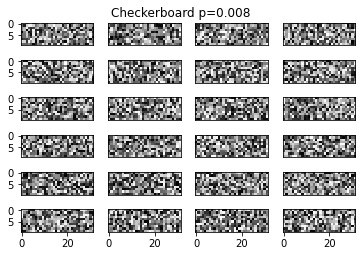

In [ ]:
plt.figure()
to_plot = np.random.rand(24,10,32)*2-1
gs = plot_2d_sta(to_plot, gs=gridspec.GridSpec(6, 4), pval=0.008)

In [ ]:
#export
def plot_dome_flat(sph_pos, ax=None, **scatter_args):
    """
    Plot the dome LED as flat.
    
    params:
        - sph_pos: Spherical coordinates of the LED (e.g. obtained with `leddome.get_dome_positions`)
        - ax: The axis for the plot. Needs to be polar projection. If None, a new plot is created
        - scatter_args: Args for the scatter plot, such as the dots individual colors
        
    return:
        - The axis of the plot
        
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='polar')
    sph_pos = np.reshape(sph_pos, (-1,3))
    ax.scatter(sph_pos[:,2]+np.pi, sph_pos[:,1], **scatter_args)
    ax.set_yticks(ticks=[])
    ax.set_xticks(ticks=[])
    ax.set_ylim(0,np.pi/2)
    ax.grid(b=False)
    return ax
    
def plot_dome_checker(sta, s=20, gs=None, pval=None, title="Checkerboard"):
    """
    Plot a single 2D STA or an iterable of 2D STAs for the LED dome
    
    params:
        - sta: Array of shape (h, w) or of shape (n_sta, h, w)
        - s: The dot size
        - gs: GridSpec for the plotting. If None, defined automatically
        - pval: Minimal p-value of the whole
        - title: Title to give to the GridSpec
        
    return:
        - the GridSpec
        
    """
    if gs is None:
        n_col = int(np.sqrt(len(sta))*1.618)
        n_row = len(sta)//n_col
        if n_col*n_row<len(sta):
            n_row += 1     
        gs = gridspec.GridSpec(n_row, n_col)

    grid_x, grid_y = gs.get_geometry()
    for i in range(grid_x):
        for j in range(grid_y):
            if (j+i*grid_y)>=len(sta):
                break
            ax = plt.subplot(gs[i*grid_y+j], projection='polar')
            plot_dome_flat(get_dome_positions(mode="spherical"), ax=ax,
                           s=s, c=sta[i*grid_y+j], vmin=-1, vmax=1, cmap="gray")
            if i==0 and j==1:
                if pval is None:
                    ax.set_title(title)
                else:
                    ax.set_title(title+" p="+format_pval(pval))
    return gs

In [ ]:
#export
def plot_crosscorr_spikes_behav(behav, corr_behav_lag, p_value_peak, offset_peak, null_dist_behav, fps=60, seconds=30, color_line='black', title='visual stim', ax=None):
    """
    Cross-correlation with lag plotting helper function.
    
    params:
        - behav: String with name of behavioral signal to be analysed 
        - corr_behav_lag: Array of values of the cross-correlation between behavioral signal and spiking signal (output of 'utils.cross_corr_with_lag')
        - p_value_peak: P-value of the peak correlation between behavioral signal and spiking signal (output of 'utils.cross_corr_with_lag')
        - offset_peak: Offset value in seconds of the peak correlation value from the centered correlation value (output of 'utils.cross_corr_with_lag')
        - null_dist_behav: Null distribution of correlation values (output of 'utils.cross_corr_with_lag')
        - fps: Sampling rate
        - seconds: Window in seconds of the correlation lag
        - color_line: Color of plotted line 
        - title: Title of the plot
        - ax: The axis for the plot
    
    return:
        - The axis of the figure
    """
    
    ax.plot(corr_behav_lag, color=color_line)
    ax.axvline(np.ceil(len(corr_behav_lag)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(abs(np.array(corr_behav_lag))),color='r',linestyle='--',label='Peak synchrony')
    #Plot shaded section corresponding to 2.5th-97.5th percentile of the null dist
    ax.axhspan(np.percentile(null_dist_behav, 2.5), np.percentile(null_dist_behav, 97.5), facecolor='grey', alpha=0.5, label='2.5th-97.5th percentile null dist')
    ax.set_title('\n'+title+f'\n Offset = {offset_peak} seconds, p peak={p_value_peak} \n'+ behav + ' signal leads <> Spiking signal leads', fontsize= 7)
    ax.set_ylim(min(corr_behav_lag),max(corr_behav_lag))
    ax.set_xlabel('Offset (s)', fontsize=8)
    ax.set_ylabel('Pearson r', fontsize=8)
    ax.set_xticks([0, fps*seconds, fps*seconds*2])
    ax.set_xticklabels([-seconds, 0, seconds])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(loc=0, fontsize=6)
    
    return ax

In [ ]:
#export
def configure_pyplot_recap(small_size=14, medium_size=18, bigger_size=24):
    """
    Set the fontsize and other style of matplotlib and seaborn for the recap plots. 
    Call sns.set() and plt.rcdefaults() to restore defaults parameters.
    """
    plt.rc('font', size=small_size)          # controls default text sizes
    plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=small_size)    # legend fontsize
    plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title
    
    sns.set_context("notebook", rc={"font.size":small_size,
                                    "axes.titlesize":small_size,
                                    "axes.labelsize":medium_size,
                                    "xtick.labelsize":small_size,
                                    "ytick.labelsize":small_size,
                                    "legend.fontsize":small_size,
                                    "figure.titlesize":bigger_size})
    sns.set_style("white")
    sns.set_style("ticks")

In [ ]:
#export
def plot_recap_vivo_ephy(title_dict, reM, phy_dict, cluster_ids, df_stim, cell_db_ids=None,
                         checkerboard=None, fullfield_fl=None, fl_bars=None, chirp_am=None, 
                         chirp_fm=None, moving_gratings=None, water=None, export_path="./recap_plot.pdf"):
    """
    Plot the recap pdf of in vivo electrophy records.
    
    params:
        - title_dict: A dictionnary containing the str info for the title: keys(condition, date, record_name, record_id)
        - reM: The record master object of the record
        - phy_dict: A dictionnary containing the results from phy (see utils.phy_results_dict())
        - cluster_ids: A list of the cluster id used by phy, to plot. Usually the cells classified as good.
        - df_stim: Stimulus dataframe recap of their syncronisation obtained with `utils.stim_recap_df`
        - cell_db_ids: A list of the database ids of the cells corresponding to cluster_ids.
        - checkerboard: A matrix of STA of cells to the checkerboard stimulus of shape (n_cell, 16, height, width)
        - fullfield_fl: A matrix of STA of cells to the fullfield_flicker stimulus of shape (n_cell, 16)
        - fl_bars: A matrix of STA of cells to the flickering_bars stimulus of shape (n_cell, 16, height, width)
        - chirp_am: A tuple of the chirp_am obtained from a pipe, where [0] is the stimulus and [1] the cells response
        - chirp_fm: Same as chirp_am but for a chirp_fm stimulus
        - moving_gratings: The dict of response obtained from `utils.group_direction_response`
        - water: A matrix of STA of cells to the water stimulus of shape (n_cell, 16, height, width)
        - export_path: The path for a pdf file to be exported. If None, the plot is displayed.
    """
    print("Generating the recap plot")
    configure_pyplot_recap()
    
    shanks_idx = buszaki_shank_channels(phy_dict["channel_positions"])
    cond = title_dict["condition"]
    date = title_dict["date"]
    record_name = title_dict["record_name"]
    record_id = title_dict["record_id"]
    
    if cell_db_ids is None:
        cell_db_ids = [-1]*len(cluster_ids)
    
    with PdfPages(export_path) as pp:
        
        #Plotting Cover
        fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
        gs  = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
        ax_rem  = fig.add_subplot(gs[:10,2:-1])
        reM.plot(ax_rem)

        ax_stim_recap  = fig.add_subplot(gs[11:16,:])
        plot_stim_recap_table(df_stim, ax=ax_stim_recap)
        suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id)])
        plt.suptitle(suptitle)

        pp.savefig()
        plt.close()

        for cluster, cell_id in zip(cluster_ids, cell_db_ids):
            reM_cell_idx = reM["S_matrix"][0].attrs["cell_map"][cluster]#np.where(cluster==cluster_ids)[0][0]

            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
            suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id), 
                                   "Cluster n°"+str(cluster), "Cell id n°"+str(cell_id)])
            plt.suptitle(suptitle)

            mask_cluster = phy_dict["spike_clusters"]==cluster
            cluster_composition = np.unique(phy_dict["spike_templates"][mask_cluster])

            gs = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)

            #Template on electrodes
            cell_loc_ax = fig.add_subplot(gs[0:4,0:2])
            plot_spike_template(cluster_composition, phy_dict["templates"], shanks_idx, phy_dict["channel_positions"], ax=cell_loc_ax)

            #Autocorrelogram
            autocorr_ax = fig.add_subplot(gs[0:4,3:7])
            plot_autocorrelogram(cluster, phy_dict["spike_times"], phy_dict["spike_clusters"], 
                                 bin_ms=.001, sampling_rate=30000, tails=30, ax=autocorr_ax)

            #Spike amplitude across time
            sp_amp_ax = fig.add_subplot(gs[0:4,8:])
            plot_spike_amplitudes(cluster, phy_dict["spike_templates"], phy_dict["spike_clusters"], 
                                  phy_dict["spike_times"], phy_dict["amplitudes"], ax=sp_amp_ax)
            plot_stim_epochs_to_ephy(reM, y_pos=-0.05, ax=sp_amp_ax)

            #Checkerboard STA
            if checkerboard is not None:
                pval_checker = checkerboard[1][reM_cell_idx]
                pval_checker = np.min(pval_checker[pval_checker!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(checkerboard[0][reM_cell_idx], pval=pval_checker, gs=inner_grid, title="Checkerboard")
            #Water STA
            elif water is not None:
                pval_water = water[1][reM_cell_idx]
                pval_water = np.min(pval_water[pval_water!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(water[0][reM_cell_idx], pval=pval_water, gs=inner_grid, title="Water")
                
            #Fullfield flickering STA
            if fullfield_fl is not None:
                pval_fffl = fullfield_fl[1][reM_cell_idx]
                pval_fffl = np.min(pval_fffl[pval_fffl!=0])
                sp_amp_ax = fig.add_subplot(gs[5:12,13:])
                plot_t_sta(fullfield_fl[0][reM_cell_idx], pval=pval_fffl, ax=sp_amp_ax)

            #Chirp_FM
            if chirp_fm is not None:
                chirpfm_ax = fig.add_subplot(gs[13:16,:])
                plot_chirp(chirp_fm[0], chirp_fm[1][:,reM_cell_idx], smooth=False, ax=chirpfm_ax)
                chirpfm_ax.set_title("Chirp FM")

            #Chirp_AM
            if chirp_am is not None:
                chirpam_ax = fig.add_subplot(gs[17:20,:])
                plot_chirp(chirp_am[0], chirp_am[1][:,reM_cell_idx], smooth=False, ax=chirpam_ax)
                chirpam_ax.set_title("Chirp AM")

            #Flickering bars
            if fl_bars is not None:
                pval_bars = fl_bars[1][reM_cell_idx]
                pval_bars = np.min(pval_bars[pval_bars!=0])
                fl_bars_ax = fig.add_subplot(gs[21:,:12])
                plot_fl_bars(fl_bars[0][reM_cell_idx], pval=pval_bars, ax=fl_bars_ax)

            #Moving gratings
            if moving_gratings is not None:
                ds_ax = fig.add_subplot(gs[21:,13:], projection="polar")
                plot_ds_wheel(moving_gratings, cell_idx=reM_cell_idx, ax=ds_ax)

            pp.savefig()
            plt.close()

            print("Cell cluster n°",cluster,"done")

    sns.set()
    plt.rcdefaults()
    print()

In [ ]:
#export
def plot_recap_vivo_calcium(title_dict, reM, A_matrix, cell_traces, df_stim, cell_indexes=None, cell_db_ids=None, 
                         checkerboard=None, fullfield_fl=None, fl_bars=None, chirp_am=None, 
                         chirp_fm=None, moving_gratings=None, water=None, export_path="./recap_plot.pdf"):
    """
    Plot the recap pdf of in vivo calcium records.
    
    params:
        - title_dict: A dictionnary containing the str info for the title: keys(condition, date, record_name, record_id)
        - reM: The record master object of the record
        - A_matrix: A matrix of the cell spatial components obtained from CaImAn
        - cell_traces: Cells raw traces (C or S_matrix from CaImAn)
        - df_stim: Stimulus dataframe recap of their syncronisation obtained with `utils.stim_recap_df`
        - cell_indexes: A list of the indexes of the cell to plot. Leave to None for plotting all of them.
        - cell_db_ids: A list of the database ids of the cells corresponding to cluster_ids.
        - checkerboard: A matrix of STA of cells to the checkerboard stimulus of shape (n_cell, 64, height, width)
        - fullfield_fl: A matrix of STA of cells to the fullfield_flicker stimulus of shape (n_cell, 64)
        - chirp_am: A tuple of the chirp_am obtained from a pipe, where [0] is the stimulus and [1] the cells response
        - chirp_fm: Same as chirp_am but for a chirp_fm stimulus
        - moving_gratings: The dict of response obtained from `utils.group_direction_response`
        - water: A matrix of STA of cells to the water stimulus of shape (n_cell, 16, height, width) 
        - export_path: The path for a pdf file to be exported. If None, the plot is displayed.
    """
    
    print("Generating the recap plot")
    configure_pyplot_recap()

    cond = title_dict["condition"]
    date = title_dict["date"]
    record_name = title_dict["record_name"]
    record_id = title_dict["record_id"]
    if cell_indexes is None:
        cell_indexes = list(range(len(A_matrix)))
    if cell_db_ids is None:
        cell_db_ids = [-1]*len(cell_indexes)
    
    with PdfPages(export_path) as pp:
        
        #Plotting Cover
        fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
        gs  = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
        ax_rem  = fig.add_subplot(gs[:10,2:-1])
        reM.plot(ax_rem)

        ax_stim_recap  = fig.add_subplot(gs[11:16,:])
        plot_stim_recap_table(df_stim, ax=ax_stim_recap)

        #Flipping the A_matrix to correspond to the STA orientation
        A_matrix = np.rot90(A_matrix[:,::-1], axes=(1,2))
        ax_axon_terminals  = fig.add_subplot(gs[17:28,1:10])
        plot_composed_A_masks(A_matrix, ax=ax_axon_terminals)
        ax_axon_terminals.set_title("Axon terminals (Flipped + Rot90)")

        if checkerboard is not None:
            ax_checkersta_pos = fig.add_subplot(gs[17:22,11:])
            plot_sta_positions(checkerboard[0], ax_checkersta_pos)
            ax_checkersta_pos.set_title("Checkerboard STA fits")
        
        if water is not None:
            ax_watersta_pos = fig.add_subplot(gs[23:28,11:])
            plot_sta_positions(water[0], ax_watersta_pos)
            ax_watersta_pos.set_title("Water STA fits")

        suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id)])
        plt.suptitle(suptitle)

        pp.savefig()
        plt.close()

        for cell_idx, cell_db_id in zip(cell_indexes, cell_db_ids):

            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches(damn) *2
            suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id), 
                                   "Cell n°"+str(cell_idx), "Cell DB id n°"+str(cell_db_id)])
            plt.suptitle(suptitle)

            gs = gridspec.GridSpec(28, 20, left=0.05, 
                                   right=.95, top=.92, 
                                   bottom=.05, wspace=0.00, hspace=0.00)

            #Template on electrodes
            cell_loc_ax = fig.add_subplot(gs[0:4,0:4])
            plot_cell_spatial(A_matrix[cell_idx], ax=cell_loc_ax)

            #Spike amplitude across time
            calcium_trace_ax = fig.add_subplot(gs[0:4,5:])
            plot_calcium_trace(cell_traces[:, cell_idx], ax=calcium_trace_ax)
            plot_stim_epochs_to_calcium(reM, y_pos=-0.3, ax=calcium_trace_ax)

            #Checkerboard STA
            if checkerboard is not None:
                pval_checker = checkerboard[1][cell_idx]
                pval_checker = np.min(pval_checker[pval_checker!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(checkerboard[0][cell_idx][::4], pval=pval_checker, gs=inner_grid, title="Checkerboard")

            #Fullfield flickering STA
            if fullfield_fl is not None:
                pval_fffl = fullfield_fl[1][cell_idx]
                pval_fffl = np.min(pval_fffl[pval_fffl!=0])
                sp_amp_ax = fig.add_subplot(gs[5:12,13:])
                plot_t_sta(fullfield_fl[0][cell_idx], pval=pval_fffl, ax=sp_amp_ax)

            #Chirp_FM
            if chirp_fm is not None:
                chirpfm_ax = fig.add_subplot(gs[13:16,:])
                plot_chirp(chirp_fm[0], chirp_fm[1][:,cell_idx], ax=chirpfm_ax)
                chirpfm_ax.set_title("Chirp FM")

            #Chirp_AM
            if chirp_am is not None:
                chirpam_ax = fig.add_subplot(gs[17:20,:])
                plot_chirp(chirp_am[0], chirp_am[1][:,cell_idx], ax=chirpam_ax)
                chirpam_ax.set_title("Chirp AM")

            #Water
            if water is not None:
                pval_water = water[1][cell_idx]
                pval_water = np.min(pval_water[pval_water!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[21:,:12], wspace=.09, hspace=.13)
                plot_2d_sta(water[0][cell_idx][::4], pval=pval_water, gs=inner_grid, title="Water")

            #Moving gratings
            if moving_gratings is not None:
                #The very small values of calcium need a normalization to higher values
                # for plotting purpose
                all_val = None
                for i, (k,v) in enumerate(moving_gratings.items()):
                    if all_val is None:
                        all_val = np.zeros((len(moving_gratings), *v[0].shape))
                    all_val[i] = v[0]
                for k,v  in moving_gratings.items():
                    moving_gratings[k] = ((v[0].T / np.max(all_val, axis=(0,2))).T*100, *v[1:])

                ds_ax = fig.add_subplot(gs[21:,13:], projection="polar")
                plot_ds_wheel(moving_gratings, cell_idx=cell_idx, ax=ds_ax)

            pp.savefig()
            plt.close()

            print("Cell n°",cell_idx,"done")

    sns.set()
    plt.rcdefaults()
    print()
    

In [ ]:
#export
def plot_recap_vitro_ephy(title_dict, reM, phy_dict, cluster_ids, df_stim, cell_db_ids=None,
                         checkerboard=None, fullfield_fl=None, fl_bars=None, chirp_am=None, 
                         chirp_fm=None, moving_gratings=None, export_path="./recap_plot.pdf"):
    """
    Plot the recap pdf of in vitro electrophy records.
    
    params:
        - title_dict: A dictionnary containing the str info for the title: keys(condition, date, record_name, record_id)
        - reM: The record master object of the record
        - phy_dict: A dictionnary containing the results from phy (see utils.phy_results_dict())
        - cluster_ids: A list of the cluster id used by phy, to plot. Usually the cells classified as good.
        - df_stim: Stimulus dataframe recap of their syncronisation obtained with `utils.stim_recap_df`
        - cell_db_ids: A list of the database ids of the cells corresponding to cluster_ids.
        - checkerboard: A matrix of STA of cells to the checkerboard stimulus of shape (n_cell, 16, height, width)
        - fullfield_fl: A matrix of STA of cells to the fullfield_flicker stimulus of shape (n_cell, 16)
        - fl_bars: A matrix of STA of cells to the flickering_bars stimulus of shape (n_cell, 16, height, width)
        - chirp_am: A tuple of the chirp_am obtained from a pipe, where [0] is the stimulus and [1] the cells response
        - chirp_fm: Same as chirp_am but for a chirp_fm stimulus
        - moving_gratings: The dict of response obtained from `utils.group_direction_response`
        - export_path: The path for a pdf file to be exported. If None, the plot is displayed.
    """
    
    print("Generating the recap plot")
    configure_pyplot_recap()
    
    cond = title_dict["condition"]
    date = title_dict["date"]
    record_name = title_dict["record_name"]
    record_id = title_dict["record_id"]
    
    if cell_db_ids is None:
        cell_db_ids = [-1]*len(cluster_ids)
    
    with PdfPages(export_path) as pp:
        
        #Plotting Cover
        fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
        gs  = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
        ax_rem  = fig.add_subplot(gs[:10,2:-1])
        reM.plot(ax_rem)

        ax_stim_recap  = fig.add_subplot(gs[11:16,:])
        plot_stim_recap_table(df_stim)
        suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id)], ax=ax_stim_recap)
        plt.suptitle(suptitle)

        pp.savefig()
        plt.close()

        for cluster, cell_id in zip(cluster_ids, cell_db_ids):
            reM_cell_idx = reM["S_matrix"][0].attrs["cell_map"][cluster]#np.where(cluster==cluster_ids)[0][0]

            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
            suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id), 
                                   "Cluster n°"+str(cluster), "Cell id n°"+str(cell_id)])
            plt.suptitle(suptitle)

            mask_cluster = phy_dict["spike_clusters"]==cluster
            cluster_composition = np.unique(phy_dict["spike_templates"][mask_cluster])

            gs = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)

            #Template on electrodes
            cell_loc_ax = fig.add_subplot(gs[0:4,0:4])
            plot_spike_template_MEA(cluster_composition, phy_dict["templates"], phy_dict["channel_positions"], ax=cell_loc_ax)

            #Autocorrelogram
            autocorr_ax = fig.add_subplot(gs[0:4,5:9])
            plot_autocorrelogram(cluster, phy_dict["spike_times"], phy_dict["spike_clusters"], 
                                 bin_ms=.001, sampling_rate=30000, tails=30, ax=autocorr_ax)

            #Spike amplitude across time
            sp_amp_ax = fig.add_subplot(gs[0:4,10:])
            plot_spike_amplitudes(cluster, phy_dict["spike_templates"], phy_dict["spike_clusters"], 
                                  phy_dict["spike_times"], phy_dict["amplitudes"], ax=sp_amp_ax)
            plot_stim_epochs_to_ephy(reM, y_pos=0.2, ax=sp_amp_ax)

            #Checkerboard STA
            if checkerboard is not None:
                pval_checker = checkerboard[1][reM_cell_idx]
                pval_checker = np.min(pval_checker[pval_checker!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(checkerboard[0][reM_cell_idx], pval=pval_checker, gs=inner_grid)

            #Fullfield flickering STA
            if fullfield_fl is not None:
                pval_fffl = fullfield_fl[1][reM_cell_idx]
                pval_fffl = np.min(pval_fffl[pval_fffl!=0])
                sp_amp_ax = fig.add_subplot(gs[5:12,13:])
                plot_t_sta(fullfield_fl[0][reM_cell_idx], pval=pval_fffl, ax=sp_amp_ax)

            #Chirp_FM
            if chirp_fm is not None:
                chirpfm_ax = fig.add_subplot(gs[13:16,:])
                plot_chirp(chirp_fm[0], chirp_fm[1][:,reM_cell_idx], smooth=False, ax=chirpfm_ax)
                chirpfm_ax.set_title("Chirp FM")

            #Chirp_AM
            if chirp_am is not None:
                chirpam_ax = fig.add_subplot(gs[17:20,:])
                plot_chirp(chirp_am[0], chirp_am[1][:,reM_cell_idx], smooth=False, ax=chirpam_ax)
                chirpam_ax.set_title("Chirp AM")

            #Flickering bars
            if fl_bars is not None:
                pval_bars = fl_bars[1][reM_cell_idx]
                pval_bars = np.min(pval_bars[pval_bars!=0])
                fl_bars_ax = fig.add_subplot(gs[21:,:12])
                plot_fl_bars(fl_bars[0][reM_cell_idx], pval=pval_bars, ax=fl_bars_ax)

            #Moving gratings
            if moving_gratings is not None:
                ds_ax = fig.add_subplot(gs[21:,13:], projection="polar")
                plot_ds_wheel(moving_gratings, cell_idx=reM_cell_idx, ax=ds_ax)

            pp.savefig()
            plt.close()

            print("Cell cluster n°",cluster,"done")

    sns.set()
    plt.rcdefaults()
    print()

In [ ]:
#export
def plot_recap_vivo_ephy_dome(title_dict, reM, phy_dict, cluster_ids, cell_db_ids=None,
                         checkerboard=None, fullfield_fl=None, chirp_am=None, 
                         chirp_fm=None, moving_gratings=None, export_path="./recap_plot.pdf"):
    """
    Plot the recap pdf of in vivo electrophy records with the LED dome as stimuluation device.
    
    params:
        - title_dict: A dictionnary containing the str info for the title: keys(condition, date, record_name, record_id)
        - reM: The record master object of the record
        - phy_dict: A dictionnary containing the results from phy (see utils.phy_results_dict())
        - cluster_ids: A list of the cluster id used by phy, to plot. Usually the cells classified as good.
        - df_stim: Stimulus dataframe recap of their syncronisation obtained with `utils.stim_recap_df`
        - cell_db_ids: A list of the database ids of the cells corresponding to cluster_ids.
        - checkerboard: A matrix of STA of cells to the checkerboard stimulus of shape (n_cell, 16, height, width)
        - fullfield_fl: A matrix of STA of cells to the fullfield_flicker stimulus of shape (n_cell, 16)
        - fl_bars: A matrix of STA of cells to the flickering_bars stimulus of shape (n_cell, 16, height, width)
        - chirp_am: A tuple of the chirp_am obtained from a pipe, where [0] is the stimulus and [1] the cells response
        - chirp_fm: Same as chirp_am but for a chirp_fm stimulus
        - moving_gratings: The dict of response obtained from `utils.group_direction_response`
        - export_path: The path for a pdf file to be exported. If None, the plot is displayed.
    """
    
    print("Generating the recap plot")
    configure_pyplot_recap()
    
    shanks_idx = buszaki_shank_channels(phy_dict["channel_positions"])
    cond = title_dict["condition"]
    date = title_dict["date"]
    record_name = title_dict["record_name"]
    record_id = title_dict["record_id"]
    
    if cell_db_ids is None:
        cell_db_ids = [-1]*len(cluster_ids)
    
    with PdfPages(export_path) as pp:
        
        #Plotting Cover
        fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
        gs  = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
        ax_rem  = fig.add_subplot(gs[:10,2:-1])
        reM.plot(ax_rem)

        suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id)])
        plt.suptitle(suptitle)

        pp.savefig()
        plt.close()

        for cluster, cell_id in zip(cluster_ids, cell_db_ids):
            reM_cell_idx = reM["S_matrix"][0].attrs["cell_map"][cluster]#np.where(cluster==cluster_ids)[0][0]

            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
            suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id), 
                                   "Cluster n°"+str(cluster), "Cell id n°"+str(cell_id)])
            plt.suptitle(suptitle)

            mask_cluster = phy_dict["spike_clusters"]==cluster
            cluster_composition = np.unique(phy_dict["spike_templates"][mask_cluster])

            gs = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)

            #Template on electrodes
            cell_loc_ax = fig.add_subplot(gs[0:4,0:2])
            plot_spike_template(cluster_composition, phy_dict["templates"], shanks_idx, phy_dict["channel_positions"], cell_loc_ax)

            #Autocorrelogram
            autocorr_ax = fig.add_subplot(gs[0:4,3:7])
            plot_autocorrelogram(cluster, phy_dict["spike_times"], phy_dict["spike_clusters"], 
                                 bin_ms=.001, sampling_rate=30000, tails=30, ax=autocorr_ax)

            #Spike amplitude across time
            sp_amp_ax = fig.add_subplot(gs[0:4,8:])
            plot_spike_amplitudes(cluster, phy_dict["spike_templates"], phy_dict["spike_clusters"], 
                                  phy_dict["spike_times"], phy_dict["amplitudes"], ax=sp_amp_ax)
            plot_stim_epochs_to_ephy(reM, y_pos=0.2, ax=sp_amp_ax)

            #Checkerboard STA
            if checkerboard is not None:
                pval_checker = checkerboard[1][reM_cell_idx]
                pval_checker = np.min(pval_checker[pval_checker!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(2, 8,
                            subplot_spec=gs[5:12,:], wspace=.09, hspace=.13)
                plot_dome_checker(checkerboard[0][reM_cell_idx], s=8, pval=pval_checker, gs=inner_grid)

            #Fullfield flickering STA
            if fullfield_fl is not None:
                pval_fffl = fullfield_fl[1][reM_cell_idx]
                pval_fffl = np.min(pval_fffl[pval_fffl!=0])
#                 sp_amp_ax = fig.add_subplot(gs[5:12,13:])
                sp_amp_ax = fig.add_subplot(gs[21:,:12])
                plot_t_sta(fullfield_fl[0][reM_cell_idx], pval=pval_fffl, ax=sp_amp_ax)

            #Chirp_FM
            if chirp_fm is not None:
                chirpfm_ax = fig.add_subplot(gs[13:16,:])
                plot_chirp(chirp_fm[0], chirp_fm[1][:,reM_cell_idx], smooth=False, ax=chirpfm_ax)
                chirpfm_ax.set_title("Chirp FM")

            #Chirp_AM
            if chirp_am is not None:
                chirpam_ax = fig.add_subplot(gs[17:20,:])
                plot_chirp(chirp_am[0], chirp_am[1][:,reM_cell_idx], smooth=False, ax=chirpam_ax)
                chirpam_ax.set_title("Chirp AM")

            #Moving gratings
            if moving_gratings is not None:
                ds_ax = fig.add_subplot(gs[21:,13:], projection="polar")
                plot_ds_wheel(moving_gratings, cell_idx=reM_cell_idx, ax=ds_ax)

            pp.savefig()
            plt.close()

            print("Cell cluster n°",cluster,"done")

    sns.set()
    plt.rcdefaults()
    print()

In [ ]:
#export
def plot_recap_vivo_ephy_corr_behav(title_dict, reM, phy_dict, cluster_ids, df_stim, behavs, conversion_factor_treadmill=6.25, removeslowdrifts=True, cell_db_ids=None,
                         checkerboard=None, fullfield_fl=None, fl_bars=None, chirp_am=None, 
                         chirp_fm=None, moving_gratings=None, water=None, export_path="./recap_plot_corr_behav.pdf"):
    """
    Plot the recap pdf of in vivo electrophy records.
    
    params:
        - title_dict: A dictionary containing the str info for the title: keys(condition, date, record_name, record_id)
        - reM: The record master object of the record
        - phy_dict: A dictionary containing the results from phy (see utils.phy_results_dict())
        - cluster_ids: A list of the cluster id used by phy, to plot. Usually the cells classified as good.
        - df_stim: Stimulus dataframe recap of their syncronisation obtained with `utils.stim_recap_df`
        - behavs: A list with behavioral signal names from reM to plot the correlation with spiking signal
        - conversion_factor_treadmill: The value to convert the treadmill signal into cm/s
        - removeslowdrifts: Boolean:
                False - does not remove slow drifts from the signal, for the correlation analysis; 
                True - removes slow drifts by extracting a specified percentile within moving window from the signal, for the correlation analysis.
        - cell_db_ids: A list of the database ids of the cells corresponding to cluster_ids.
        - checkerboard: A matrix of STA of cells to the checkerboard stimulus of shape (n_cell, 16, height, width)
        - fullfield_fl: A matrix of STA of cells to the fullfield_flicker stimulus of shape (n_cell, 16)
        - fl_bars: A matrix of STA of cells to the flickering_bars stimulus of shape (n_cell, 16, height, width)
        - chirp_am: A tuple of the chirp_am obtained from a pipe, where [0] is the stimulus and [1] the cells response
        - chirp_fm: Same as chirp_am but for a chirp_fm stimulus
        - moving_gratings: The dict of response obtained from `utils.group_direction_response`
        - water: A matrix of STA of cells to the water stimulus of shape (n_cell, 16, height, width)
        - export_path: The path for a pdf file to be exported. If None, the plot is displayed.
    """
    print("Generating the recap plot")
    configure_pyplot_recap()
    
    shanks_idx = buszaki_shank_channels(phy_dict["channel_positions"])
    cond = title_dict["condition"]
    date = title_dict["date"]
    record_name = title_dict["record_name"]
    record_id = title_dict["record_id"]
    
    if cell_db_ids is None:
        cell_db_ids = [-1]*len(cluster_ids)
    
    with PdfPages(export_path) as pp:
        
        #Plotting Cover
        fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
        gs  = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
        ax_rem  = fig.add_subplot(gs[:10,2:-1])
        reM.plot(ax_rem)

        ax_stim_recap  = fig.add_subplot(gs[11:16,:])
        plot_stim_recap_table(df_stim, ax=ax_stim_recap)
        suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id)])
        plt.suptitle(suptitle)

        pp.savefig()
        plt.close()

        for cluster, cell_id in zip(cluster_ids, cell_db_ids):
            reM_cell_idx = reM["S_matrix"][0].attrs["cell_map"][cluster]#np.where(cluster==cluster_ids)[0][0]

            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
            suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id), 
                                   "Cluster n°"+str(cluster), "Cell id n°"+str(cell_id)])
            plt.suptitle(suptitle)

            mask_cluster = phy_dict["spike_clusters"]==cluster
            cluster_composition = np.unique(phy_dict["spike_templates"][mask_cluster])

            gs = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)

            #Template on electrodes
            cell_loc_ax = fig.add_subplot(gs[0:4,0:2])
            plot_spike_template(cluster_composition, phy_dict["templates"], shanks_idx, phy_dict["channel_positions"], ax=cell_loc_ax)

            #Autocorrelogram
            autocorr_ax = fig.add_subplot(gs[0:4,3:7])
            plot_autocorrelogram(cluster, phy_dict["spike_times"], phy_dict["spike_clusters"], 
                                 bin_ms=.001, sampling_rate=30000, tails=30, ax=autocorr_ax)

            #Spike amplitude across time
            sp_amp_ax = fig.add_subplot(gs[0:4,8:])
            plot_spike_amplitudes(cluster, phy_dict["spike_templates"], phy_dict["spike_clusters"], 
                                  phy_dict["spike_times"], phy_dict["amplitudes"], ax=sp_amp_ax)
            plot_stim_epochs_to_ephy(reM, y_pos=0.2, ax=sp_amp_ax)

            #Checkerboard STA
            if checkerboard is not None:
                pval_checker = checkerboard[1][reM_cell_idx]
                pval_checker = np.min(pval_checker[pval_checker!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(checkerboard[0][reM_cell_idx], pval=pval_checker, gs=inner_grid, title="Checkerboard")
            #Water STA
            elif water is not None:
                pval_water = water[1][reM_cell_idx]
                pval_water = np.min(pval_water[pval_water!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(water[0][reM_cell_idx], pval=pval_water, gs=inner_grid, title="Water")
                
            #Fullfield flickering STA
            if fullfield_fl is not None:
                pval_fffl = fullfield_fl[1][reM_cell_idx]
                pval_fffl = np.min(pval_fffl[pval_fffl!=0])
                sp_amp_ax = fig.add_subplot(gs[5:12,13:])
                plot_t_sta(fullfield_fl[0][reM_cell_idx], pval=pval_fffl, ax=sp_amp_ax)

            #Chirp_FM
            if chirp_fm is not None:
                chirpfm_ax = fig.add_subplot(gs[13:16,:])
                plot_chirp(chirp_fm[0], chirp_fm[1][:,reM_cell_idx], smooth=False, ax=chirpfm_ax)
                chirpfm_ax.set_title("Chirp FM")

            #Chirp_AM
            if chirp_am is not None:
                chirpam_ax = fig.add_subplot(gs[17:20,:])
                plot_chirp(chirp_am[0], chirp_am[1][:,reM_cell_idx], smooth=False, ax=chirpam_ax)
                chirpam_ax.set_title("Chirp AM")

            #Flickering bars
            if fl_bars is not None:
                pval_bars = fl_bars[1][reM_cell_idx]
                pval_bars = np.min(pval_bars[pval_bars!=0])
                fl_bars_ax = fig.add_subplot(gs[21:,:12])
                plot_fl_bars(fl_bars[0][reM_cell_idx], pval=pval_bars, ax=fl_bars_ax)

            #Moving gratings
            if moving_gratings is not None:
                ds_ax = fig.add_subplot(gs[21:,13:], projection="polar")
                plot_ds_wheel(moving_gratings, cell_idx=reM_cell_idx, ax=ds_ax)

            pp.savefig()
            plt.close()
            
            #Adding aditional page just for correlation plots between ephy spike_counts signal with behavioral signals 
            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
            
            seq = reM._sequences[0]
            stim_names = seq.get_names_group("stim")
            
            gs = gridspec.GridSpec(28, (len(stim_names)+1)*7, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
            
            coord1=0
            coord2=4
            coord3=0
            coord4=5
            
            for index, behav_signal_name in enumerate(behavs):
                ax = fig.add_subplot(gs[coord1:coord2,coord3:coord4])
                pipe = Data_Pipe(reM, ["S_matrix", behav_signal_name])
                pipe += "main_tp"
                pipe -= "signals"
                if behav_signal_name == "treadmill":
                    spike_counts = pipe[0]["S_matrix"][:,reM_cell_idx]
                    behav_signal = pipe[0][behav_signal_name]
                    title_name = "Speed"
                elif behav_signal_name == "eye_tracking":
                    spike_counts = pipe[0]["S_matrix"][:,reM_cell_idx]
                    behav_signal =  pipe[0][behav_signal_name][:,2] * pipe[0][behav_signal_name][:,3] * np.pi
                    title_name = "Pupil size"
                else:
                    spike_counts = pipe[0]["S_matrix"][:,reM_cell_idx]
                    behav_signal =  pipe[0][behav_signal_name][:,2] * pipe[0][behav_signal_name][:,3] * np.pi
                    title_name = str(behav_signal_name)
                crosscorr, corr_peak, p_value_peak, offset_peak, null_dist_corr = cross_corr_with_lag(spike_counts, behav_signal, behav_signal_name, conversion_factor_treadmill=conversion_factor_treadmill, removeslowdrift=removeslowdrifts, fps=60, seconds=30)
                plot_crosscorr_spikes_behav(title_name, crosscorr, p_value_peak, offset_peak, null_dist_corr, fps=60, seconds=30, color_line=DEFAULT_COLORS[0], title='dark', ax=ax)
                
                coord3+=7
                coord4=coord3+5
                    
                for index, stim_name in enumerate(stim_names):
                    ax = fig.add_subplot(gs[coord1:coord2,coord3:coord4])
                    pipe = Data_Pipe(reM, ["S_matrix", behav_signal_name])
                    pipe += stim_name 
                    if behav_signal_name == "treadmill":
                        spike_counts = pipe[0]["S_matrix"][:,reM_cell_idx]
                        behav_signal = pipe[0][behav_signal_name]
                        title_name = "Speed"
                    elif behav_signal_name == "eye_tracking":
                        spike_counts = pipe[0]["S_matrix"][:,reM_cell_idx]
                        behav_signal =  pipe[0][behav_signal_name][:,2] * pipe[0][behav_signal_name][:,3] * np.pi
                        title_name = "Pupil size"
                    else:
                        spike_counts = pipe[0]["S_matrix"][:,reM_cell_idx]
                        behav_signal =  pipe[0][behav_signal_name][:,2] * pipe[0][behav_signal_name][:,3] * np.pi
                        title_name = str(behav_signal_name)
                    crosscorr, corr_peak, p_value_peak, offset_peak, null_dist_corr = cross_corr_with_lag(spike_counts, behav_signal, behav_signal_name, conversion_factor_treadmill=conversion_factor_treadmill, removeslowdrift=removeslowdrifts, fps=60, seconds=30)
                    plot_crosscorr_spikes_behav(title_name, crosscorr, p_value_peak, offset_peak, null_dist_corr, fps=60, seconds=30, color_line=DEFAULT_COLORS[index+1], title=stim_name, ax=ax)
                    
                    coord3+=7
                    coord4=coord3+5
                    
                coord1+=7
                coord2+=7
                coord3=0
                coord4=5
                
            pp.savefig()
            plt.close()   
            print("Cell cluster n°",cluster,"done")
    
    if removeslowdrifts == 0:        
        print("Slowdrifts were not removed from signals to perform the correlation analysis.")
    
    sns.set()
    plt.rcdefaults()
    print()

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
